__A tutorial and template for *PersLay: a neural network layer for persistence diagrams and new graph topological signatures*.__

__Author:__ Théo Lacombe, Mathieu Carrière

__Note:__ This is an alpha version of PersLay. Do not hesitate to contact the authors for any comment, suggestion, bug, etc.

__Outline:__
In this notebook:
- First, we select a dataset. Two types of datasets are provided by default, either synthetic orbits from dynamical systems, or real-life graph dataset (we also explain how you could use PersLay with your own persistence diagrams).
- Then, we generate the persistence diagrams (and other useful informations such as labels, etc.) for the chosen dataset, and optionally visualize them.
- We either load a predefined PersLay neural net, or define a neural net that uses some PersLay channels as first layers to handle persistence diagrams. This can be used as a guideline to use PersLay in your own experiments.
- We show how to train this neural network.

# Import required Python libraries

Print the current version of Python.

In [1]:
import sys
print("Current version of your system: (we recommand Python 3.6)")
print(sys.version)

Current version of your system: (we recommand Python 3.6)
3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


Import Numpy, Scikit-learn, TensorFlow, PersLay.

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from tensorflow import random_uniform_initializer as rui

In [3]:
from perslay import PerslayModel

In [4]:
from experiments import *

# (Optional) Generate predefined persistence diagrams

__Note:__ Skip this section and go to Section 3 if you already have your own persistence diagrams.

We start by choosing the dataset we want to run the experiments on. We suggest the user to start with `"MUTAG"` as this dataset is reasonably small (188 graphs with 18 nodes on average). Note that its small size implies a large variability in test accuracies.

Available options are:

- Orbit datasets: `"ORBIT5K"`, `"ORBIT100K"`.

- Graphs datasets: `"MUTAG"`,`"COX2"`, `"DHFR"`, `"PROTEINS"`, `"NCI1"`, `"NCI109"`,`"IMDB-BINARY"`, `"IMDB-MULTI"`.

__Important note:__ `"COLLAB"`,`"REDDIT5K"` and `"REDDIT12K"` are not available yet (see README.md). Contact the authors for more information.

Beware that for the datasets (`"COLLAB"`,`"REDDIT5K", "REDDIT12K", "ORBIT100K"`), the files can be quite large (e.g. 3Gb for for `"ORBIT100K"`), so that RAM can be limiting, and the time needed to generate the persistence diagrams and run the experiments can be quite long depending on the hardware available. Dataset descriptions are available in Section B of the supplementary material of the article.

In [5]:
dataset = "MUTAG"

Here, we implicitely load our data (saved as `.mat` files for graphs datasets, and generated on-the-fly for orbits datasets---which can take some time for `"ORBIT100K"` especially), and then compute the persistence diagrams that will be used in the classification experiment (requires to have `gudhi` installed). For graph datasets, we also generate a series of additional features (see [1]).

Running `generate_diag_and_features` will store diagrams, features and labels. Therefore, it is sufficient to run it just once (for each different dataset). Note that for bigger datasets, the computations of these persistence diagrams can be quite long.

In [6]:
generate_diagrams_and_features(dataset, path_dataset="./data/MUTAG/")

Now we load and preprocess persistence diagrams (to make them PersLay-compatible) and other useful items using the files that we have generated.

In [7]:
diags_dict, F, L = load_data(dataset, path_dataset="./data/MUTAG/")

In [8]:
F = np.array(F, dtype=np.float64)

##### Visualize persistence diagrams

Run the following cell to visualise some example of diagrams generated.

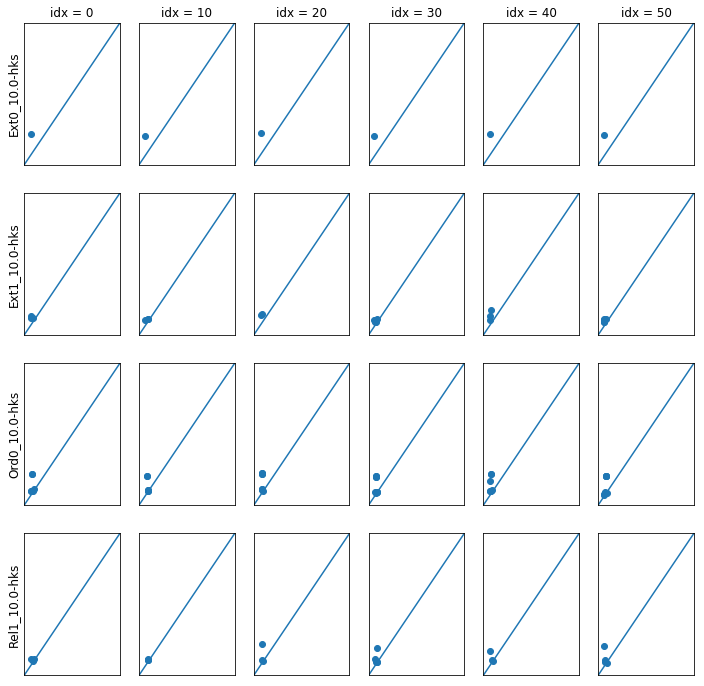

In [9]:
visualize_diagrams(diags_dict)

# (Optional) Use your own persistence diagrams

__Note:__ Skip this section and make sure to go through Section 2 if you want to use the predefined persistence diagrams that we provide.

We provide a (hopefully) convenient way to use your own persistence diagrams for a classification task (with some eventual features).

Persistence diagrams must be given in the following format:
assume you have $N$ observations. For each of them, you build $K$ different persistence diagrams (e.g. persistence diagrams in different homology dimensions, and/or for different filtrations, etc.). 

Then, you must provide a `diags_dict` variable that is a `dictionary`, whose $K$ keys are the persistence diagram type names (e.g. `"Rips_dim_0"`, `"Cech_dim_1"`). For each key $k_i$, $1 \leq i \leq K$, the corresponding value is a `list` of `np.arrays`, each array encoding a persistence diagram. 

Note that each list must have the same length $N$ (you need to have the same number of persistence diagrams generated for each list). Note also that you must keep the order (i.e. the first element of each list must correspond to the persistence diagram generated with the first observation, and so on).

Below is an example of such a (very simple) dictionary, with two filtrations and two persistence diagrams in each:

`diags_tmp = {"Alpha0":[np.array([[0.1, 0.2], [0.2, 0.5], [0.3, 0.9]]), np.array([[0.1, 0.4], [0.3, 0.5]]),], "Alpha1":[np.array([[0.1, 0.4], [0.2, 0.6], [0.4, 0.9]]), np.array([[0.1, 0.2], [0.5, 0.7], [0.8, 0.9]])]}`

In [ ]:
### To use your own diagrams, uncomment and complete the following
#diags_dict = ...

Now, you must (obviously) provide the labels corresponding to each persistence diagram (be careful to keep the same order).

In [ ]:
### To use your own labels, uncomment and complete the following
#L = ...

You can use some additional "standard" features in your network. These features must be provided as a $N \times d$ `np.array`, where $N$ is your number of observations (as before) and $d$ is the dimension of your features.

If you do not want to use additional features, you must use an empty array of size $(N,0)$, where $N$ is the number of observations.

In [ ]:
### Uncomment and complete the following line to not include additional features with PersLay.
#N = # number of observations
#F = np.array([[]]*N)

### To use your own features instead, uncomment and complete the following
#F = ...

If your persistence diagrams have not been preprocessed already, we now apply a preprocessing that makes our sets of persistence diagrams compatible with PersLay.

# (Optional) Preprocess persistence diagrams

In [10]:
import gudhi.representations as tda

### Uncomment the following to process your diagrams (necessary)
thresh = 500

# Whole pipeline
tmp = Pipeline([
        ("Selector",      tda.DiagramSelector(use=True, point_type="finite")),
        ("ProminentPts",  tda.ProminentPoints(use=True, num_pts=thresh)),
        ("Scaler",        tda.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())])),
        ("Padding",       tda.Padding(use=True)),
                ])

prm = {filt: {"ProminentPts__num_pts": min(thresh, max([len(dgm) for dgm in diags_dict[filt]]))} 
       for filt in diags_dict.keys() if max([len(dgm) for dgm in diags_dict[filt]]) > 0}

# Apply the previous pipeline on the different filtrations.
diags = []
for dt in prm.keys():
    param = prm[dt]
    tmp.set_params(**param)
    diags.append(tmp.fit_transform(diags_dict[dt]))

# For each filtration, concatenate all diagrams in a single array.
D, npts = [], len(diags[0])
for dt in range(len(prm.keys())):
    D.append(np.array(np.concatenate([diags[dt][i][np.newaxis,:] for i in range(npts)],axis=0),dtype=np.float32))

# Using PersLay in a neural network

## (Optional) Load network architecture

In [11]:
model, optimizer, loss, metrics = get_model(dataset, F.shape[1])

## (Optional) Define your own network

You might want to define your own PersLay architecture and to use your own optimizers, losses and/or metrics. To help you with it, we now show the different options regarding the parameters of PersLay.

Initialize list of parameters for PersLay. This list will contain the different PersLay channel parameters (there is one channel per filtration/diagram type).

In [ ]:
perslay_parameters = []

In [ ]:
perslay_channel = {}

In [ ]:
perslay_channel["pweight_train"] = True
perslay_channel["layer_train"]   = True
perslay_channel["final_model"]   = "identity"

##### Layer type

Choice of layer type, must be one of (see README.md and [1] for details):
- `"Image"` for a persistence image layer.
- `"PermutationEquivariant"` for a permutation equivariant layer (as in [2]).
- `"Exponential"` for an exponential structure element layer (as in [3]).
- `"Rational"` for a rational structure element layer (as in [3]).
- `"RationalHat"` for a rational hat structure element layer (as in [3]).
- `"Landscape"` for a persistence landscape layer.
- `"BettiCurve"` for a Betti curve layer.
- `"Entropy"` for a persistence entropy layer.

In [ ]:
perslay_channel["layer"]           = "Image"
perslay_channel["image_size"]      = (20, 20)
perslay_channel["image_bnds"]      = ((-.001, 1.001), (-.001, 1.001))
perslay_channel["lvariance_init"]  = 3.

In [ ]:
perslay_channel["layer"]           = "PermutationEquivariant"
perslay_channel["lpeq"]            = [(5, "max")]
perslay_channel["lweight_init"]    = rui(0.0, 1.0)
perslay_channel["lbias_init"]      = rui(0.0, 1.0)
perslay_channel["lgamma_init"]     = rui(0.0, 1.0)

In [ ]:
perslay_channel["layer"]           = "Exponential"
perslay_channel["lnum"]            = 25
perslay_channel["lmean_init"]      = rui(0.0, 1.0)
perslay_channel["lvariance_init"]  = rui(3.0, 3.0)

In [ ]:
perslay_channel["layer"]           = "Rational"
perslay_channel["lnum"]            = 25
perslay_channel["lmean_init"]      = rui(0.0, 1.0)
perslay_channel["lvariance_init"]  = rui(3.0, 3.0) 
perslay_channel["lalpha_init"]     = rui(3.0, 3.0) 

In [ ]:
perslay_channel["layer"]           = "RationalHat"
perslay_channel["lnum"]            = 25
perslay_channel["lmean_init"]      = rui(0.0, 1.0)
perslay_channel["lr_init"]         = rui(3.0, 3.0) 
perslay_channel["q"]               = 2

In [ ]:
perslay_channel["layer"]           = "Landscape"
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 

In [ ]:
perslay_channel["layer"]           = "BettiCurve"
perslay_channel["theta"]           = 10
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 

In [ ]:
perslay_channel["layer"]           = "Entropy"
perslay_channel["theta"]           = 10
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 

##### Weight function

Choice of the weight function, must be one of:
- `"power"`, for the distance to the diagonal with some exponent.
- `"grid"`, for a piecewise-constant function defined with pixel values.
- `"gmix"`, for a weight function defined as a mixture of Gaussians.
- `None`, for a constant weight function. 

In [ ]:
perslay_channel["pweight"]       = "power"
perslay_channel["pweight_init"]  = 1.
perslay_channel["pweight_power"] = 1

In [ ]:
perslay_channel["pweight"]       = "grid"
perslay_channel["pweight_size"]  = [20,20]
perslay_channel["pweight_bnds"]  = ((-.001, 1.001), (-.001, 1.001))
perslay_channel["pweight_init"]  = rui(1.0, 1.0)

In [ ]:
perslay_channel["pweight"]       = "gmix"
perslay_channel["pweight_num"]   = 3
perslay_channel["pweight_init"]  = np.array(np.vstack([np.random.uniform(0.,1.,[2,3]), 
                                                        5.*np.ones([2,3])]), dtype=np.float32)

In [ ]:
perslay_channel["pweight"]       = None

##### Permutation-invariant operation

Choice of permutation invariant operator, must be one of:
- `"sum"`.
- `"topk"`, will select the $k$ highest values, specified in `keep`.
- `"max"`.
- `"mean"`.

In [ ]:
perslay_channel["perm_op"] = "sum"

In [ ]:
perslay_channel["perm_op"] = "topk"
perslay_channel["keep"]    = 5

In [ ]:
perslay_channel["perm_op"] = "max"

In [ ]:
perslay_channel["perm_op"] = "mean"

##### Definition of model and choice of optimizer, loss and metric

We use the same channel type for all filtrations and diagram types.

In [ ]:
perslay_parameters = [perslay_channel for _ in range(len(D))]

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    
    # Final rho network is a simple dense layer to the number of labels 
    rho = tf.keras.Sequential([tf.keras.layers.Dense(L.shape[1], activation="sigmoid", input_shape=(16039,))])
    model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)

    # Optimizer is Adam with exponential decay of learning rate and moving average of variables
    lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.01, decay_steps=20, decay_rate=0.5)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
    optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 

    # Loss is cross-entropy
    loss = tf.keras.losses.CategoricalCrossentropy()

    # Metric is accuracy
    metrics = [tf.keras.metrics.CategoricalAccuracy()]

## Train the network

In [12]:
num_pts = len(D[0])

### Single run

Single run means using the `evaluate_model` function for training the PersLay architecture once and observing the performance (classification accuracy) on the test set.
- For orbit datasets, we suggest to use a 70-30 train-test split, i.e. `test_size = 0.3`.
- For graph datasets, we suggest to use a 90-10 train-test split, i.e. `test_size = 0.1`.

In [13]:
test_size = .3
epochs    = 100

In [14]:
random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

W1013 22:41:41.977936 140365654808320 deprecation.py:506] From /home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


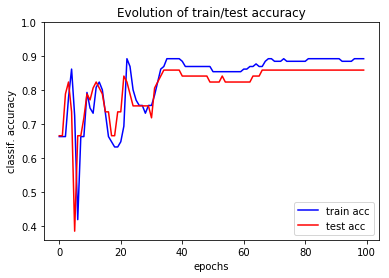

In [15]:
_, tr, te = evaluate_model(L,F,D,train,test,model,optimizer,loss,metrics,num_epochs=epochs,verbose=0,plots=True)

In [16]:
print("Train accuracy = " + str(tr[1]) + ", test accuracy = " + str(te[1]))

Train accuracy = 0.8931297659873962, test accuracy = 0.859649121761322


##### PersLay as a vectorization method

In case you just want to learn the best vectorization with PersLay, and then apply a standard classifier, run the following cells to vectorize the diagrams and to define the standard classifiers and their parameters you want to cross-validate on.

In [ ]:
vectors = model.compute_representations(D).numpy()
train_vect, test_vect = np.hstack([vectors[train], F[train]]), np.hstack([vectors[test], F[test]])
train_labs, test_labs = np.argmax(L[train], axis=1), np.argmax(L[test], axis=1)

In [ ]:
clf      = Pipeline([("Estimator", SVC())])
clf_prms = [{"Estimator":         [RandomForestClassifier()]},
            {"Estimator":         [SVC()],
             "Estimator__kernel": ["linear", "rbf"], 
             "Estimator__C":      [0.1, 1, 10]},
            {"Estimator":         [AdaBoostClassifier()]}]
classifier = GridSearchCV(clf, clf_prms, cv=5)

In [ ]:
classifier.fit(train_vect, train_labs)
tr = classifier.score(train_vect, train_labs)
te = classifier.score(test_vect,  test_labs)

In [ ]:
print("Train accuracy = " + str(tr) + ", test accuracy = " + str(te))

### Full experiment

This section is for reproducing the article experiments (10 x 10 folds). As is, it only works for predefined models (obtained with the `get_model` function), but if you want to use your own architecture and persistence diagrams, you just have to compact your model definition (done in Section 5.2) in a single function `get_model` that you can call for each fold.

In [ ]:
num_folds = 10
epochs    = 100

In [ ]:
folds = KFold(n_splits=num_folds, random_state=42, shuffle=True).split(np.empty([num_pts]))

In [ ]:
test_size=.1
folds = ShuffleSplit(n_splits=num_folds, test_size=test_size, random_state=42).split(np.empty([num_pts]))

In [ ]:
tr, te = [], []
for (ir, ie) in folds:
    model, optimizer, loss, metrics = get_model(dataset)
    _, sr, se = evaluate_model(L, F, D, ir, ie, model, optimizer, loss, metrics, num_epochs=epochs, verbose=0)
    tr.append(sr[1])
    te.append(se[1])

In [ ]:
print("Train accuracy = " + str(np.mean(tr)) + ", test accuracy = " + str(np.mean(te)))

# Bibliography

[1] _PersLay: A Simple and Versatile Neural Network Layer for Persistence Diagrams._
Mathieu Carrière, Frederic Chazal, Yuichi Ike, Théo Lacombe, Martin Royer, Yuhei Umeda.

[2] _Deep Sets._
Manzil Zaheer, Satwik Kottur, Siamak Ravanbakhsh, Barnabas Poczos, Ruslan Salakhutdinov, Alexander Smola.
_Advances in Neural Information Processing Systems 30 (NIPS 2017)_

[3] _Learning Representations of Persistence Barcodes._
Christoph Hofer, Roland Kwitt, Marc Niethammer.
_JMLR (2019)_